# Train and save a model for each country

In [ ]:
# https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py

In [83]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf

# Dealing with temporal data
from typing import Dict, List, Tuple, Sequence

# Tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

# Load data

In [85]:
os.getcwd()

csv_path = os.path.join('..', 'inflation-forecasting', 'raw_data')

df = pd.read_csv(os.path.join(csv_path,'data_final.csv'), index_col=0)

In [86]:
df_us = df[df['country_id'] == "USA"]
df_de = df[df['country_id'] == "DE"]
df_nl = df[df['country_id'] == "NL"]
df_it = df[df['country_id'] == "IT"]
df_fr = df[df['country_id'] == "FR"]
df_es = df[df['country_id'] == "ES"]

In [87]:
df_us = df_us.dropna()

In [88]:
df_us.columns

Index(['year', 'cpi', 'ccpi', 'indprod', 'unemp', 'intrate', 'm3', 'oil_price',
       'country_id', 'country'],
      dtype='object')

In [89]:
train_dates = pd.to_datetime(df_us['year'])

cols = list(df_us)[2:7]

df_for_training = df_us[cols].astype(float)

In [90]:
df_for_training

,ccpi,indprod,unemp,intrate,m3
12,0.98361,-8.45377,6.6,1.45,5.33199
13,0.65359,-7.74411,6.9,2.54,6.06568
14,0.98039,-6.34204,6.9,2.02,6.34815
15,0.98039,-3.65304,7.0,1.49,6.59780
16,0.98039,-2.05700,7.1,1.98,7.07876
...,...,...,...,...,...
751,6.30050,3.50338,3.7,2.33,3.82332
752,6.64296,4.73131,3.5,2.56,2.56370
753,6.30176,3.18912,3.7,3.08,1.28501
754,5.97198,1.98468,3.6,3.78,0.02623


In [136]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [137]:
trainX = []
trainY = []

n_future = 1   
n_past = 12

In [138]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (732, 12, 5).
trainY shape == (732, 1).


In [139]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 64)            17920     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
42/42 [==============================] - 2s 14ms/step - loss: 0.0338 - val_loss: 0.0125
Epoch 2/5
42/42 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0082
Epoch 3/5
42/42 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0082
Epoch 4/5
42/42 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0103
Epoch 5/5
42/42 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0093


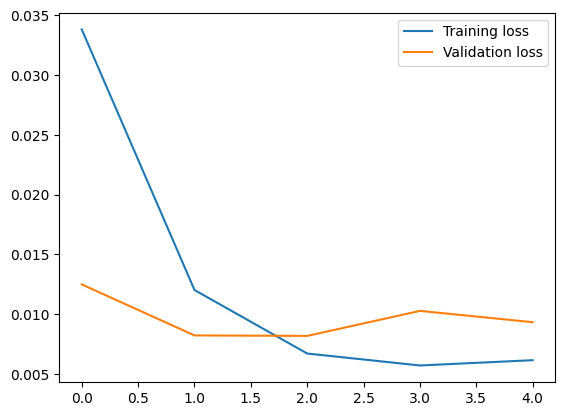

In [140]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [141]:
Predict = model.predict(trainX)

Y_hat = scaler.inverse_transform(Predict)

Y_actual = trainY

23/23 [==============================] - 0s 4ms/step


ValueError: non-broadcastable output operand with shape (732,1) doesn't match the broadcast shape (732,5)

In [132]:
df_forecast

,year,Forecast
0,2014-09-01,1.779948
1,2014-10-01,1.779835
2,2014-11-01,1.783011
3,2014-12-01,1.784288
4,2015-01-01,1.780608
...,...,...
95,2022-08-01,5.369874
96,2022-09-01,5.633718
97,2022-10-01,5.917395
98,2022-11-01,6.145093


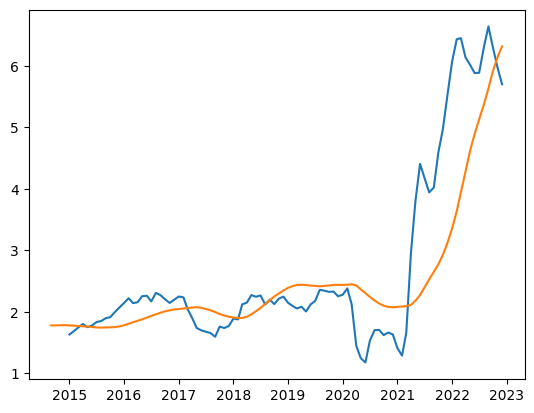

In [133]:
df_forecast = pd.DataFrame({'year':np.array(forecast_dates), 'Forecast':y_pred_future})
df_forecast['year']=pd.to_datetime(df_forecast['year'])

original = df_us[['year', 'ccpi']]
original['year']=pd.to_datetime(original['year'])
original = original.loc[original['year'] >= '2015-1-1']

plt.plot(original['year'], original['ccpi'])
plt.plot(df_forecast['year'], df_forecast['Forecast'])

In [118]:
original['ccpi']

660    1.63163
661    1.68808
662    1.74538
663    1.80283
664    1.75094
        ...   
751    6.30050
752    6.64296
753    6.30176
754    5.97198
755    5.70386
Name: ccpi, Length: 96, dtype: float64